In [39]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.2.1
certifi                      2022.12.7
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.5
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
entrypoints                  0.4
etils                        1.0.0
executing                    1.2.0
flatbuffers                  23.1.21
fonttools                    4.38.0
gast                         0.5.3
google-auth                  2.16.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
googleapis-common-protos     1.5

You should consider upgrading via the 'C:\Deep Learning Projects\AngCommands\env_angmincommands\Scripts\python.exe -m pip install --upgrade pip' command.


In [40]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-io==0.25.0 tensorflow_datasets matplotlib

You should consider upgrading via the 'C:\Deep Learning Projects\AngCommands\env_angmincommands\Scripts\python.exe -m pip install --upgrade pip' command.



IMPORT


In [41]:
import os
import pathlib

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf 
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

FUNKCJE

Teraz zdefiniujmy funkcję, która wstępnie przetwarza nieprzetworzone pliki audio WAV zestawu danych na tensory audio:

In [42]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

Zdefiniuj funkcję, która tworzy etykiety przy użyciu katalogów nadrzędnych dla każdego pliku:

In [43]:
def get_label(file_path):
    parts = tf.strings.split( input=file_path, sep=os.path.sep )
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

Zdefiniuj inną funkcję pomocniczą — get_waveform_and_label — która łączy to wszystko w jedną całość:

-Dane wejściowe to nazwa pliku audio WAV.                                                        
-Dane wyjściowe to krotka zawierająca tensory audio i etykiet gotowe do nadzorowanego uczenia się.

In [44]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

Konwertuj przebiegi na spektrogramy

Utwórz funkcję użytkową do konwersji przebiegów na spektrogramy:

Przebiegi muszą mieć tę samą długość, aby po konwersji na spektrogram wyniki miały podobne wymiary. Można to zrobić po prostu dopełniając zerami klipy audio, które są krótsze niż jedna sekunda (za pomocą tf.zeros ).

Podczas wywoływania tf.signal.stft , wybierz parametry frame_length i frame_step tak, aby wygenerowany "obraz" spektrogramu był prawie kwadratowy. Aby uzyskać więcej informacji na temat wyboru parametrów STFT, zapoznaj się z tym filmem Coursera dotyczącym przetwarzania sygnału audio i STFT.

STFT tworzy tablicę liczb zespolonych reprezentujących wielkość i fazę. Jednak w tym samouczku użyjesz tylko wielkości, którą możesz uzyskać, stosując tf.abs na wyjściu tf.signal.stft .


In [45]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 132300
    waveform = waveform[:input_len]
    zero_padding = tf.zeros( [132300] - tf.shape(waveform), dtype=tf.float32)
    
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    #equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = tf.concat([zero_padding, waveform], 0)
    
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(equal_length, frame_length=256, frame_step=32)
    
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    #    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram

In [46]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [47]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

ŚCIEŻKA DO PLIKÓW AUDIO

In [48]:
DATASET_PATH = 'data_pol'
data_dir = pathlib.Path(DATASET_PATH)

WYODRĘBNIENIE KOMEND GŁOWOSYCH PLIKÓW AUDIO

In [49]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

In [50]:
print('Commands:', commands)

Commands: ['00-odrzuc_bron' '01-obroc_sie' '02-na_kolana' '03-gleba'
 '04-rece_na_glowe']


In [51]:
for command in commands:
    print(command, len(tf.io.gfile.glob( str(os.path.join(data_dir,command)) + '/*.wav')))

00-odrzuc_bron 41
01-obroc_sie 42
02-na_kolana 41
03-gleba 40
04-rece_na_glowe 41


WYODRĘBNIENIE NAZW PLIKÓW AUDIO + PRZEMIESZANIE

----------------------------------------------------------------------

Unifikacja Danych wejściowych

In [52]:
def load_wav_16k_mono(file_path):
    # Load encoded wav file
    file_contents = tf.io.read_file(file_path)
    # Decode wav (tensor by chanels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Remove trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Reduce Amplitude to Hz set
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=44100)
    return wav

In [53]:
#Sprawdzenie rozkładu długości posiadanych próbek w przykładowej komendy

lengths = []
files = tf.io.gfile.glob(str(data_dir)+'/*/*.wav')
for file in files:
    wav = load_wav_16k_mono(file)
    lengths.append(len(wav))

In [54]:
for command in commands:
    lengths = []
    files = tf.io.gfile.glob( str(os.path.join(data_dir,command)) + '/*.wav')
    
    for file in files:
        wav = load_wav_16k_mono(file)
        lengths.append(len(wav))
        
    # Mediana długości
    command_mean = tf.math.reduce_mean(lengths)
    # Min długości
    command_min = tf.math.reduce_min(lengths)
    # Max długości
    command_max = tf.math.reduce_max(lengths)
    
    print(command + ' : mean ' + str(command_mean) + ', min ' + str(command_min) + ', max ' + str(command_max) )
    

00-odrzuc_bron : mean tf.Tensor(67109, shape=(), dtype=int32), min tf.Tensor(38400, shape=(), dtype=int32), max tf.Tensor(100864, shape=(), dtype=int32)
01-obroc_sie : mean tf.Tensor(69376, shape=(), dtype=int32), min tf.Tensor(41472, shape=(), dtype=int32), max tf.Tensor(136704, shape=(), dtype=int32)
02-na_kolana : mean tf.Tensor(65660, shape=(), dtype=int32), min tf.Tensor(47616, shape=(), dtype=int32), max tf.Tensor(91648, shape=(), dtype=int32)
03-gleba : mean tf.Tensor(56115, shape=(), dtype=int32), min tf.Tensor(41472, shape=(), dtype=int32), max tf.Tensor(87552, shape=(), dtype=int32)
04-rece_na_glowe : mean tf.Tensor(72341, shape=(), dtype=int32), min tf.Tensor(51712, shape=(), dtype=int32), max tf.Tensor(111104, shape=(), dtype=int32)


In [156]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [157]:
filenames = tf.io.gfile.glob(str(data_dir)+'/*/*.wav')

filenames = tf.random.shuffle(filenames)

In [158]:
print('Liczba wszystkich próbek : ', len(filenames))

Liczba wszystkich próbek :  205


PODZIAŁ NA ZESTAWY

In [159]:
train_files = filenames[:175]
val_files = filenames[175: 175 + 15]
test_files = filenames[175 + 15:]

BUDOWANIE ZESTAWU DO TRENOWANIA aby wyodrębnić pary etykiet

In [160]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

KILKA PRZEBIEGÓW DŹWIĘKOWYCH

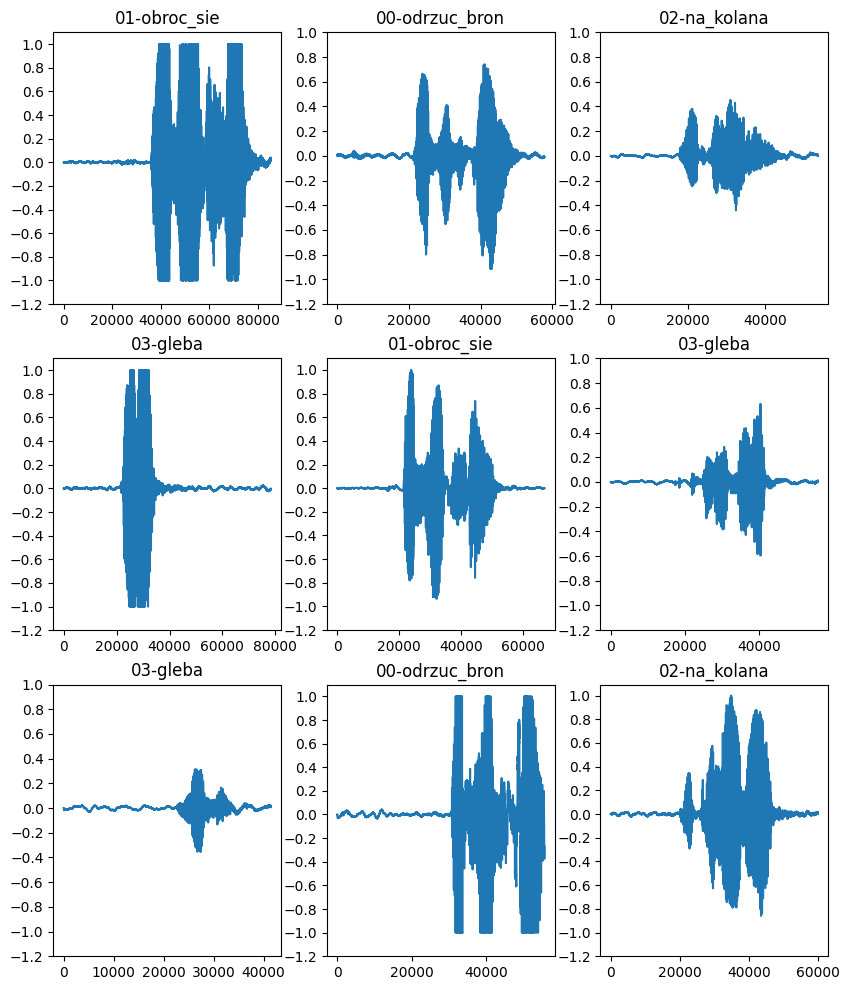

In [161]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

PRZEDSTAWIENIE PRZYKŁADOWEJ PRÓBKI 

In [162]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: 01-obroc_sie
Waveform shape: (85504,)
Spectrogram shape: (4127, 129, 1)
Audio playback


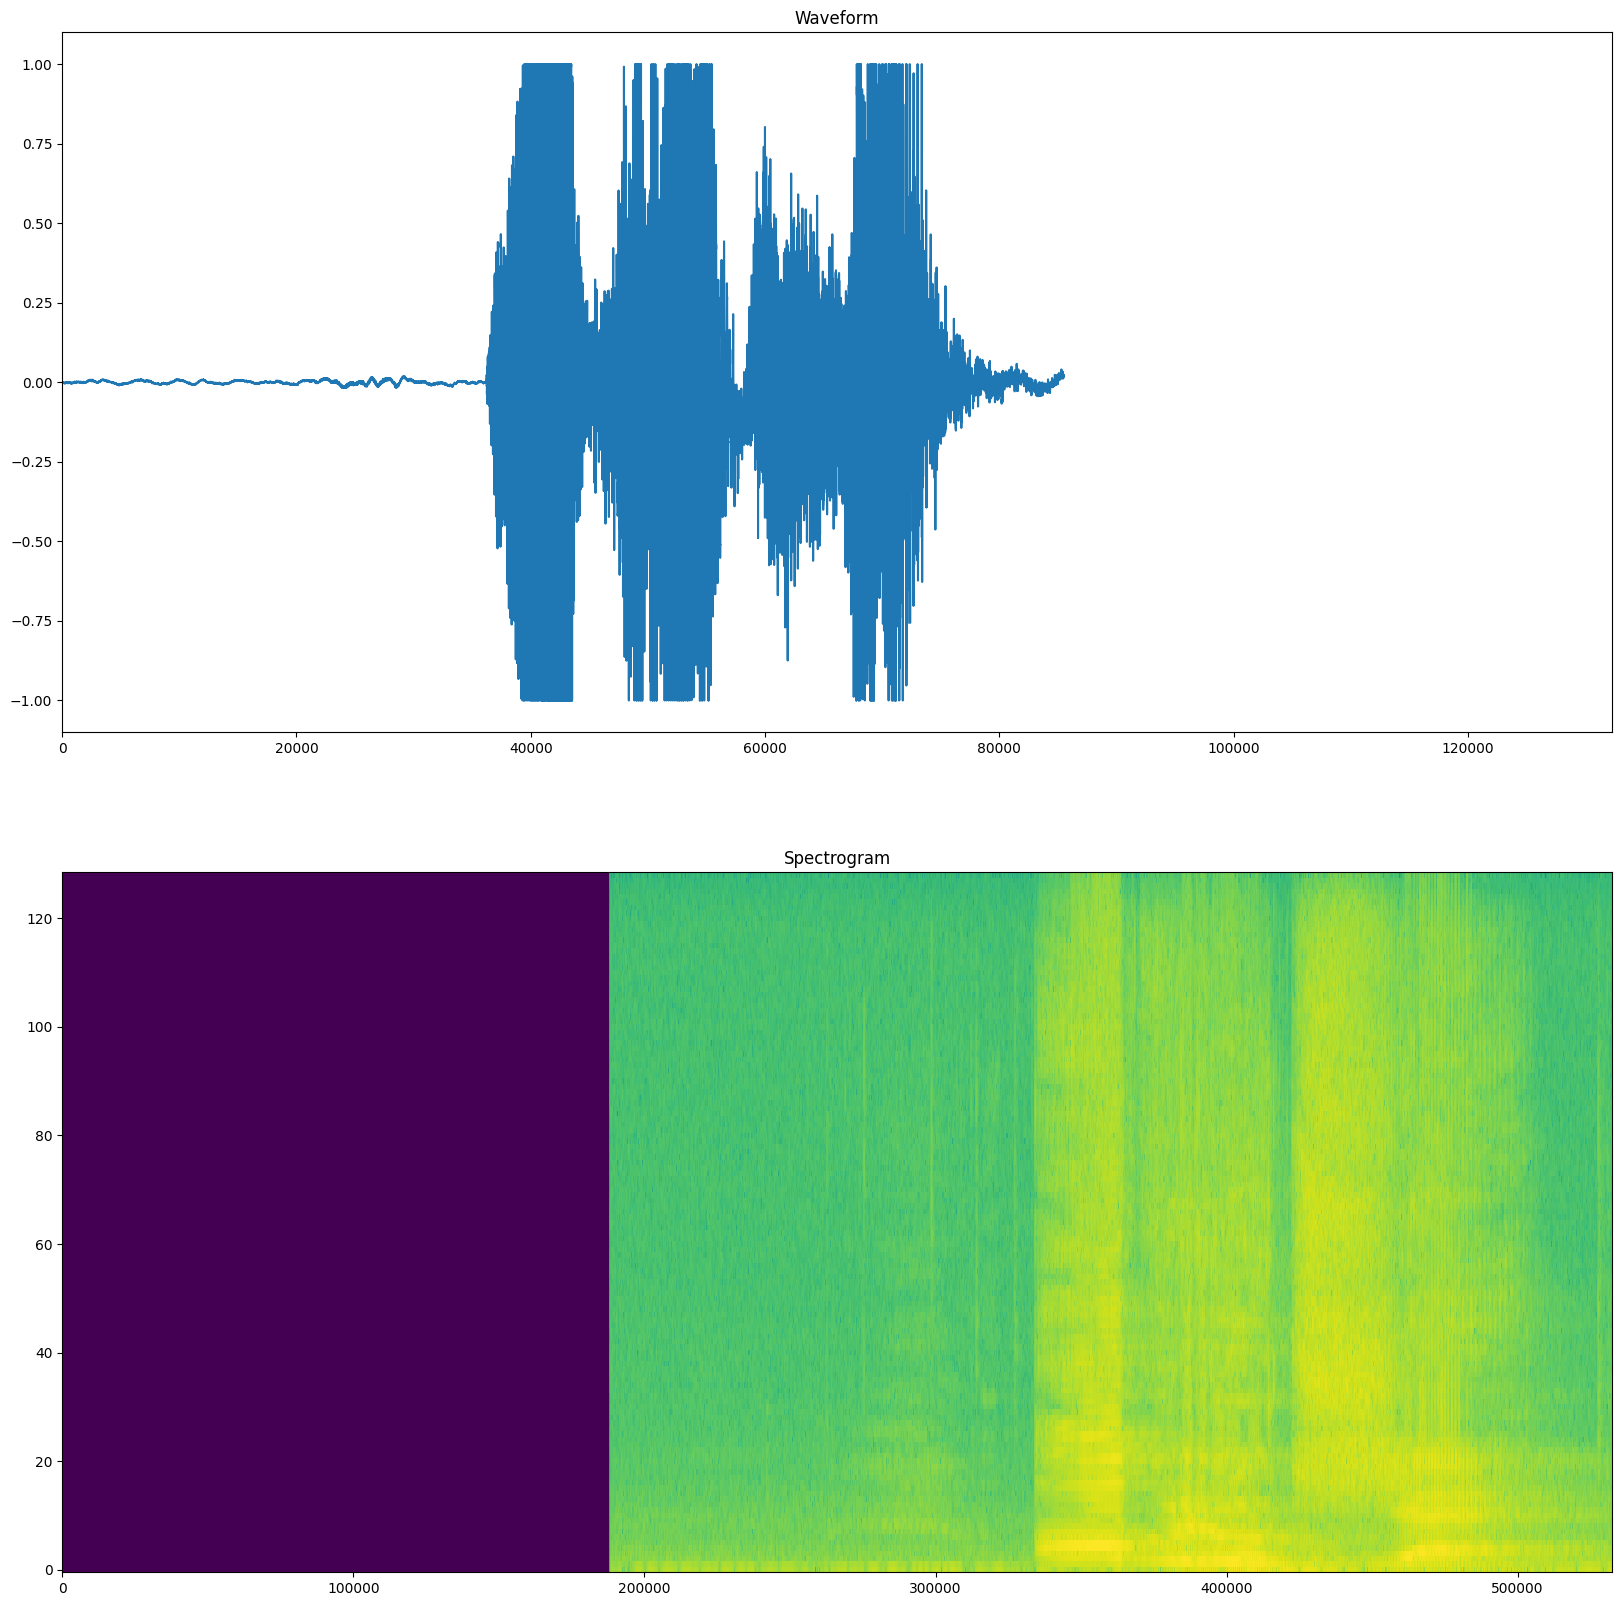

In [163]:
fig, axes = plt.subplots(2, figsize=(20, 20))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 132300])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Teraz zdefiniuj funkcję, która przekształca zbiór danych przebiegu w spektrogramy i odpowiadające im etykiety jako identyfikatory całkowite:

In [165]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Zbadaj spektrogramy pod kątem różnych przykładów zbioru danych:

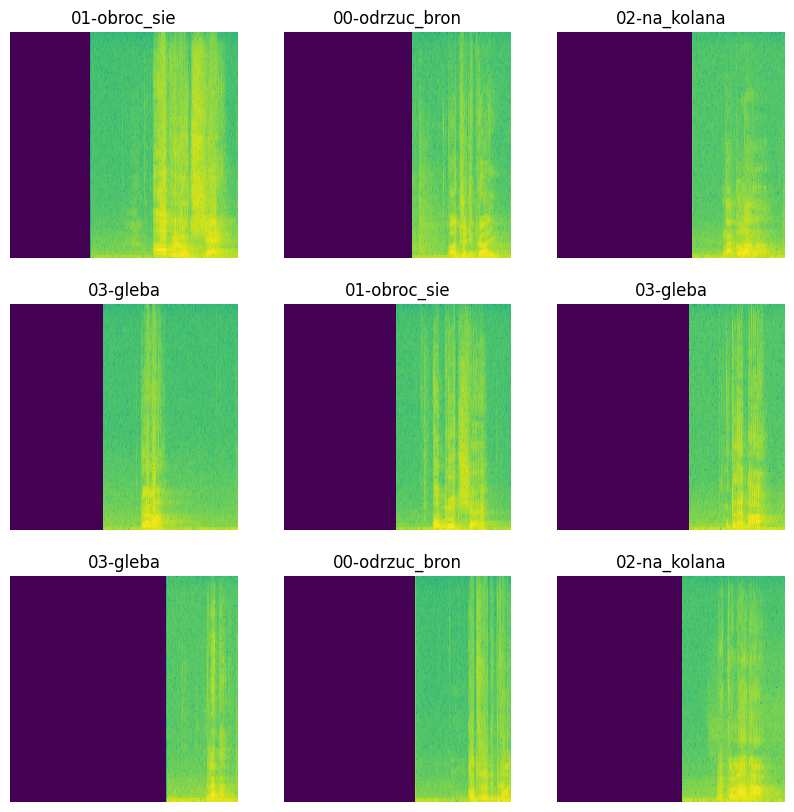

In [166]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

/***********************************************************/

BODOWANIE I TRENOWANIE MODELU

/***********************************************************/

In [167]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map( map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map( map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [168]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Wsadowe zestawy uczące i walidacyjne do uczenia modelu:

In [169]:
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Dodaj Dataset.cache i Dataset.prefetch , aby zmniejszyć opóźnienie odczytu podczas uczenia modelu:

In [170]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [171]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

W modelu użyjesz prostej splotowej sieci neuronowej (CNN), ponieważ przekształciłeś pliki audio w obrazy spektrogramów.

Twój model tf.keras.Sequential będzie korzystał z następujących warstw przetwarzania wstępnego Keras:

-tf.keras.layers.Resizing : próbkowanie danych wejściowych w dół, aby umożliwić szybsze trenowanie modelu.

-tf.keras.layers.Normalization : normalizacja każdego piksela na obrazie na podstawie jego średniej i odchylenia standardowego.

W przypadku warstwy Normalization jej metoda adapt musiałaby najpierw zostać wywołana na danych uczących w celu obliczenia zagregowanych statystyk (tj. średniej i odchylenia standardowego).

In [172]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    


In [173]:
input_shape

TensorShape([4127, 129, 1])

In [174]:
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (4127, 129, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_4 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)      

Skonfiguruj model Keras z optymalizatorem Adama i stratą entropii krzyżowej:

In [175]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Trenuj model przez 10 epok w celach demonstracyjnych:

In [191]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
44/44 [==============================] - 1s 23ms/step - loss: 0.2977 - accuracy: 0.8971 - val_loss: 2.2704 - val_accuracy: 0.7333
Epoch 2/10
44/44 [==============================] - 1s 22ms/step - loss: 0.2514 - accuracy: 0.9200 - val_loss: 3.1655 - val_accuracy: 0.8000
Epoch 3/10
44/44 [==============================] - 1s 22ms/step - loss: 0.3351 - accuracy: 0.8743 - val_loss: 2.1487 - val_accuracy: 0.6667
Epoch 4/10
44/44 [==============================] - 1s 22ms/step - loss: 0.2772 - accuracy: 0.9200 - val_loss: 2.2969 - val_accuracy: 0.6667
Epoch 5/10
44/44 [==============================] - 1s 22ms/step - loss: 0.2254 - accuracy: 0.9371 - val_loss: 2.8429 - val_accuracy: 0.7333
Epoch 6/10
44/44 [==============================] - 1s 22ms/step - loss: 0.2750 - accuracy: 0.9143 - val_loss: 2.2204 - val_accuracy: 0.7333
Epoch 7/10
44/44 [==============================] - 1s 22ms/step - loss: 0.3113 - accuracy: 0.9200 - val_loss: 3.4077 - val_accuracy: 0.8000
Epoch 8/10
44

Wykreślmy krzywe utraty treningu i walidacji, aby sprawdzić, jak poprawił się Twój model podczas uczenia:

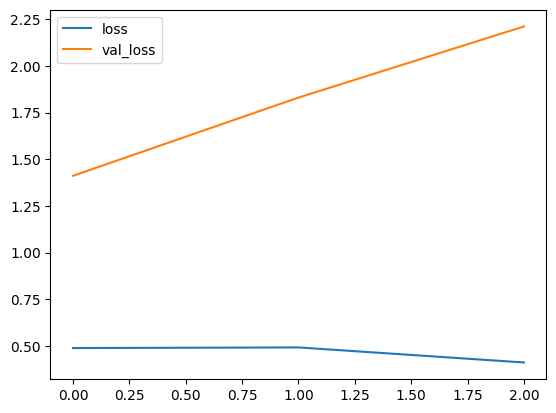

In [185]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Oceń wydajność modelu.

Uruchom model na zestawie testowym i sprawdź wydajność modelu:

In [186]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [187]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 60%


In [188]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


In [189]:
loaded_model = models.load_model('saved_model')

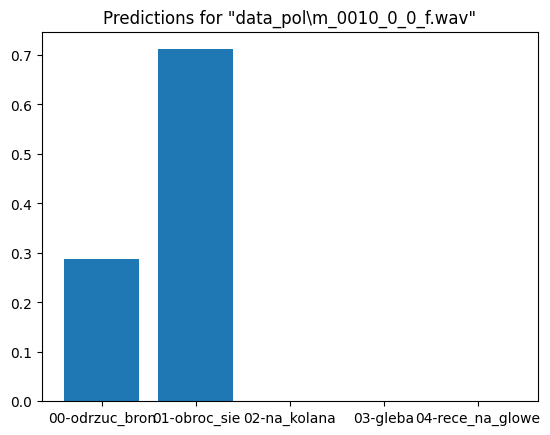

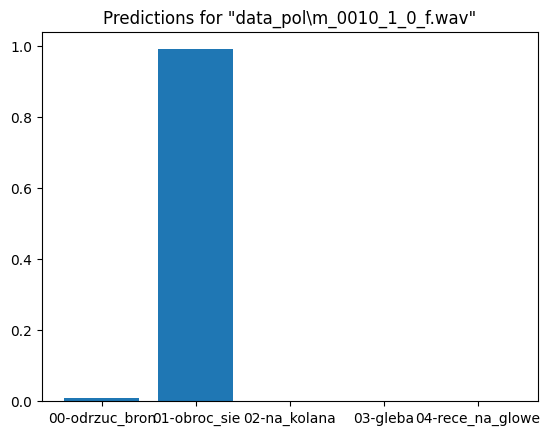

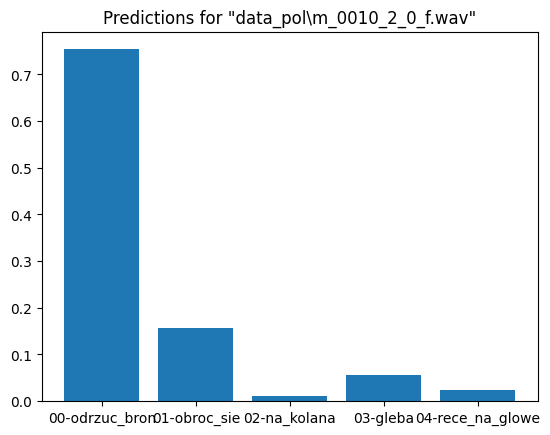

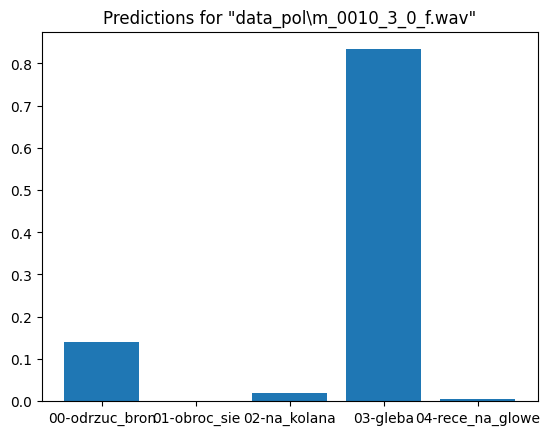

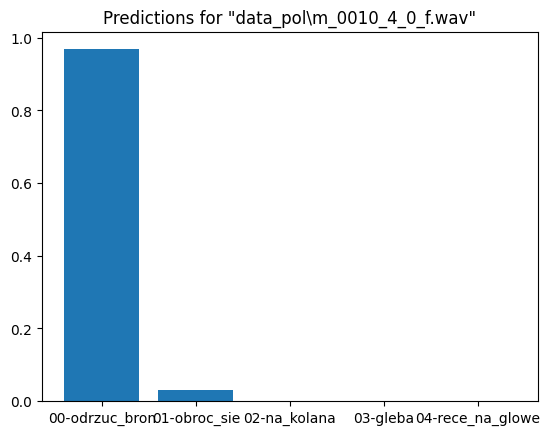

In [190]:
sample_file0 = data_dir/'m_0010_0_0_f.wav'
sample_file1 = data_dir/'m_0010_1_0_f.wav'
sample_file2 = data_dir/'m_0010_2_0_f.wav'
sample_file3 = data_dir/'m_0010_3_0_f.wav'
sample_file4 = data_dir/'m_0010_4_0_f.wav'

sample_ds = preprocess_dataset([str(sample_file0)])

for spectrogram, label in sample_ds.batch(1):
    prediction = loaded_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{str(sample_file0)}"')
    plt.show()
    
sample_ds = preprocess_dataset([str(sample_file1)])

for spectrogram, label in sample_ds.batch(1):
    prediction = loaded_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{str(sample_file1)}"')
    plt.show()
    
sample_ds = preprocess_dataset([str(sample_file2)])

for spectrogram, label in sample_ds.batch(1):
    prediction = loaded_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{str(sample_file2)}"')
    plt.show()
    
sample_ds = preprocess_dataset([str(sample_file3)])

for spectrogram, label in sample_ds.batch(1):
    prediction = loaded_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{str(sample_file3)}"')
    plt.show()
    
sample_ds = preprocess_dataset([str(sample_file4)])

for spectrogram, label in sample_ds.batch(1):
    prediction = loaded_model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{str(sample_file4)}"')
    plt.show()